# Hypothesis Testing in Healthcare: Drug Safety

A pharmaceutical company GlobalXYZ has just completed a randomized controlled drug trial. To promote transparency and reproducibility of the drug's outcome, they (GlobalXYZ) have presented the dataset to your organization, a non-profit that focuses primarily on drug safety.

The dataset provided contained five adverse effects, demographic data, vital signs, etc. Your organization is primarily interested in the drug's adverse reactions. It wants to know if the adverse reactions, if any, are of significant proportions. It has asked you to explore and answer some questions from the data.

The dataset `drug_safety.csv` was obtained from [Hbiostat](https://hbiostat.org/data/) courtesy of the Vanderbilt University Department of Biostatistics. It contained five adverse effects: headache, abdominal pain, dyspepsia, upper respiratory infection, chronic obstructive airway disease (COAD), demographic data, vital signs, lab measures, etc. The ratio of drug observations to placebo observations is 2 to 1.

For this project, the dataset has been modified to reflect the presence and absence of adverse effects `adverse_effects` and the number of adverse effects in a single individual `num_effects`.

The columns in the modified dataset are: 

| Column | Description |
|--------|-------------|
|`sex` | The gender of the individual |
|`age` | The age of the individual |
|`week` | The week of the drug testing |
|`trx` | The treatment (Drug) and control (Placebo) groups | 
|`wbc` | The count of white blood cells |
|`rbc` | The count of red blood cells |
|`adverse_effects` | The presence of at least a single adverse effect |
|`num_effects` | The number of adverse effects experienced by a single individual |

The original dataset can be found [here](https://hbiostat.org/data/repo/safety.rda).

Your organization has asked you to explore and answer some questions from the data collected. See the project instructions.

In [26]:
# Import packages
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
import pingouin
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
drug_safety = pd.read_csv("drug_safety.csv")

# Start coding here...
print(drug_safety.trx.value_counts())
print(drug_safety.adverse_effects.value_counts())
drug_safety.head()

Drug       10727
Placebo     5376
Name: trx, dtype: int64
No     14567
Yes     1536
Name: adverse_effects, dtype: int64


,age,sex,trx,week,wbc,rbc,adverse_effects,num_effects
0,62,male,Drug,0,7.3,5.1,No,0
1,62,male,Drug,1,NaN,NaN,No,0
2,62,male,Drug,12,5.6,5.0,No,0
3,62,male,Drug,16,NaN,NaN,No,0
4,62,male,Drug,2,6.6,5.1,No,0


In [27]:
# af for adverse effect, we group by Drug and Placebo, to get the adverse effects per group
adverse_effect = drug_safety.groupby('trx')['adverse_effects'].value_counts()
print(adverse_effect)
af_drug = adverse_effect[('Drug', 'Yes')]
af_placebo = adverse_effect[('Placebo', 'Yes')]

#Printing the results of adverse effects for each class of trx
print('  Drug \n', af_drug,'\n', ' Placebo\n', af_placebo)
total_drug = drug_safety[drug_safety['trx'].isin(['Drug'])]['trx'].value_counts()
print('total drug = ', total_drug[0])
total_placebo = drug_safety[drug_safety['trx'].isin(['Placebo'])]['trx'].value_counts()
print('total placebo = ', total_placebo[0])

#Verified based off of the value counts for each groups 
print('verify', 9703 + 1024 + 4864 + 512)


#Creating arrays with the successes and total for drug and placebo for the z-test
successes_dp = np.array([af_drug, af_placebo])
total_dp = np.array([total_drug[0],total_placebo[0]])
print('successes:', successes_dp, 'totals:',total_dp)

#Two sample proportion z-test 
two_sample_results = proportions_ztest(successes_dp, total_dp)
print('p value:', two_sample_results[1])
two_sample_p_value = two_sample_results[1]

trx      adverse_effects
Drug     No                 9703
         Yes                1024
Placebo  No                 4864
         Yes                 512
Name: adverse_effects, dtype: int64
  Drug 
 1024 
  Placebo
 512
total drug =  10727
total placebo =  5376
verify 16103
successes: [1024  512] totals: [10727  5376]
p value: 0.9639333330262475


In [28]:
# Performing Chi test on num_effects and trx
chi2_test = pingouin.chi2_independence(data = drug_safety, x = 'num_effects', y = 'trx')
print(chi2_test)

#Retreive the p value
num_effects_p_value = chi2_test[2]['pval'][0]
print('p value:', num_effects_p_value)

(trx                 Drug      Placebo
num_effects                          
0            9703.794883  4863.205117
1             960.587096   481.412904
2              58.621126    29.378874
3               3.996895     2.003105, trx          Drug  Placebo
num_effects               
0            9703     4864
1             956      486
2              63       25
3               5        1,                  test    lambda      chi2  dof      pval    cramer     power
0             pearson  1.000000  1.799644  3.0  0.615012  0.010572  0.176275
1        cressie-read  0.666667  1.836006  3.0  0.607131  0.010678  0.179153
2      log-likelihood  0.000000  1.922495  3.0  0.588648  0.010926  0.186033
3       freeman-tukey -0.500000  2.001752  3.0  0.572043  0.011149  0.192379
4  mod-log-likelihood -1.000000  2.096158  3.0  0.552690  0.011409  0.199984
5              neyman -2.000000  2.344303  3.0  0.504087  0.012066  0.220189)
p value: 0.6150123339426765


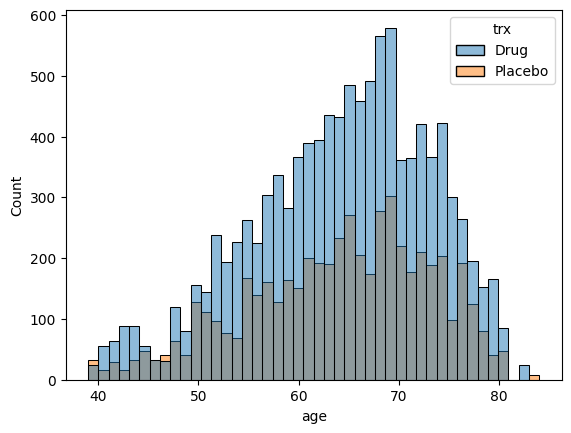

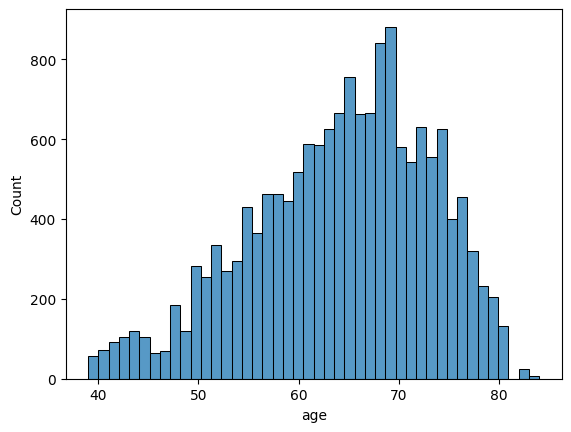

65.0


,W,pval,normal
trx,,,
Drug,0.976785,2.189152e-38,False
Placebo,0.975595,2.224950e-29,False


In [29]:
# Histogram of age by trx groups

sns.histplot(data = drug_safety, x = 'age', hue = 'trx')
plt.show()

print(drug_safety['age'].median())

#testing for normality
pingouin.normality(data = drug_safety, dv = 'age', group = 'trx')

# we can see that the data is not normaly distributed in either cases

In [30]:
#retreiving the two subgroups' age
age_drug = drug_safety[drug_safety['trx'].isin(['Drug'])]['age']
age_placebo = drug_safety[drug_safety['trx'].isin(['Placebo'])]['age']
#or done with print(drug_safety.loc[drug_safety['trx'] == 'Placebo']['age'])

mwu_test = pingouin.mwu(x = age_drug, y = age_placebo, alternative='two-sided')
print(mwu_test)
print('p val = ', mwu_test['p-val'][0])

age_group_effects_p_value = mwu_test['p-val']

          U-val alternative     p-val      RBC      CLES
MWU  29149339.5   two-sided  0.256963 -0.01093  0.505465
p val =  0.25696267004066287


In [31]:
print(two_sample_p_value)
print(num_effects_p_value)
print(age_group_effects_p_value)

0.9639333330262475
0.6150123339426765
MWU    0.256963
Name: p-val, dtype: float64
